In [43]:
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fs = 18
plt.style.use('seaborn-ticks')
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['axes.axisbelow'] = True

In [44]:
# read tech_colors.yaml with yaml and store in dictionary
import yaml
with open('tech_colors.yaml') as f:
    tech_colors = yaml.load(f, Loader=yaml.FullLoader)["tech_colors"]

tech_colors.update({'gas CHP CC':'#fdae61',
                    'solid biomass CHP': '#baa741',
                    'biomass CHP CC': '#d7191c',
                    "CSP":'#ffbf2b',
                    "gas":tech_colors["OCGT"],
                    "geothermal":"brown",
                    "VRE": "#5DBB63",
                    "SDES":tech_colors["battery"],
                    "LDES":tech_colors["H2"],
                    "stor":tech_colors["battery"],})

In [45]:
add_pypsa_link = True

In [46]:
# read results from MESSAGEix-GLOBIOM
df_gen_message = pd.read_csv("generation_MESSAGE.csv", index_col=0)*8760/1e3 # TWh
df_cap_message = pd.read_csv("capacity_MESSAGE.csv", index_col=0)

# df_gen_message_pypsa = pd.read_csv("generation_MESSAGE_w_PyPSA.csv", index_col=0)*8760/1e3 # TWh
# df_cap_message_pypsa = pd.read_csv("capacity_MESSAGE_w_PyPSA.csv", index_col=0)

df_gen_message_pypsa = pd.read_csv("generation_MESSAGE_only_curt_PyPSA_technology_link.csv", index_col=0)*8760/1e3 # TWh
df_cap_message_pypsa = pd.read_csv("capacity_MESSAGE_only_curt_PyPSA_technology_link.csv", index_col=0)

df_gen_message_only_curt = pd.read_csv("generation_MESSAGE_only_curt.csv", index_col=0)*8760/1e3 # TWh
df_cap_message_only_curt = pd.read_csv("capacity_MESSAGE_only_curt.csv", index_col=0)
df_gen_message_carbon_price = pd.read_csv("generation_MESSAGE_carbon_price_retained.csv", index_col=0)*8760/1e3 # TWh
df_cap_message_carbon_price = pd.read_csv("capacity_MESSAGE_carbon_price_retained.csv", index_col=0)

In [47]:
# Import dictionary of networks
networks = {year: pypsa.Network("C:\\Users/au485969/OneDrive - Aarhus universitet/PhD/Side projects/Side project - No gas from Russia/elec_s370_37_lv1.0__3H-T-H-B-I-A-solar+p3-dist1-cb25.7ex0_" + year + ".nc") for year in ["2050"]}
n_myopic = networks["2050"]

n_overnight = pypsa.Network("C:\\Users/au485969/OneDrive - Aarhus universitet/PhD/IIASA YSSP/pypsa/networks/new_fully_coupled_optimum_mix/elec_s370_37_lv1.0__Co2L0.05-1H-T-H-I-B-solar+p3-dist1_2030.nc")

INFO:pypsa.io:Imported network elec_s370_37_lv1.0__3H-T-H-B-I-A-solar+p3-dist1-cb25.7ex0_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s370_37_lv1.0__Co2L0.05-1H-T-H-I-B-solar+p3-dist1_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [48]:
def calculate_renewable_resources(n): 
    wind = n.generators.loc[n.generators.carrier.str.contains("wind")].index
    solar_utility = n.generators.query("carrier == 'solar'").index
    solar_rooftop = n.generators.query("carrier == 'solar rooftop'").index

    wind_resources = n.generators_t.p_max_pu[wind]*n.generators.loc[wind,"p_nom_opt"]
    solar_utility_resources = n.generators_t.p_max_pu[solar_utility]*n.generators.loc[solar_utility,"p_nom_opt"]
    solar_rooftop_resources = n.generators_t.p_max_pu[solar_rooftop]*n.generators.loc[solar_rooftop,"p_nom_opt"]

    solar_pv_capacity = (n.generators.loc[solar_utility,"p_nom_opt"].sum() + n.generators.loc[solar_rooftop,"p_nom_opt"].sum())/1e3 # GW
    wind_capacity = n.generators.loc[wind,"p_nom_opt"].sum()/1e3 # GW

    wind_generation = n.generators_t.p[wind]
    solar_utility_generation = n.generators_t.p[solar_utility]
    solar_rooftop_generation = n.generators_t.p[solar_rooftop]

    total_solar_generation = solar_utility_generation.sum().sum() + solar_rooftop_generation.sum().sum()
    total_wind_generation = wind_generation.sum().sum()
    total_solar_resources = solar_utility_resources.sum().sum() + solar_rooftop_resources.sum().sum()
    total_wind_resources = wind_resources.sum().sum()

    wind_curtailment = (total_solar_resources - total_solar_generation)/total_solar_resources*100
    solar_curtailment = (total_wind_resources - total_wind_generation)/total_wind_resources*100

    hydro = n.storage_units_t.p[n.storage_units.query("carrier == 'hydro'").index].sum().sum()

    buses = n.buses.query("carrier == 'AC'").index
    AC_generators = [x for x in n.generators.index if n.generators.loc[x].bus in buses]
    AC_generators_sum = n.generators_t.p[AC_generators].sum().sum()
    links = n.links.copy()
    links = links.drop(links.query("carrier == 'DC'").index) # without DC transmission lines
    electricity_generation_links = [x for x in links.index if links.loc[x].bus1 in buses]
    electricity_generation_links_sum = (-n.links_t.p1[electricity_generation_links]).sum().sum()
    
    # total electricity generation
    total_electricity_generation = AC_generators_sum + electricity_generation_links_sum + hydro

    # total variable renewable energy generation
    total_variable_renewable_energy_generation = total_solar_generation + total_wind_generation 

    # VRE share
    VRE_share = total_variable_renewable_energy_generation/total_electricity_generation*100

    # battery capacity
    battery_capacity = (n.links.query("carrier == 'battery discharger'").p_nom_opt.sum() + n.links.query("carrier == 'home battery discharger'").p_nom_opt.sum())/1e3 # GW
    H2_fuel_cells = n.links.query("carrier == 'H2 Fuel Cell'").p_nom_opt.sum()/1e3 # GW

    outputs = {"wind_curtailment":wind_curtailment,
               "solar_curtailment":solar_curtailment,
               "wind_capacity":wind_capacity,
               "solar_pv_capacity":solar_pv_capacity,
               "hydro":hydro,
               "total_electricity_generation":total_electricity_generation,
               "VRE_share":VRE_share}

    return outputs

In [49]:
outputs_myopic = calculate_renewable_resources(n_myopic)
outputs_overnight = calculate_renewable_resources(n_overnight)

In [50]:
outputs_myopic

{'wind_curtailment': 0.6104896298104777,
 'solar_curtailment': 0.1958395742633674,
 'wind_capacity': 1808.7027938929152,
 'solar_pv_capacity': 3968.8875379776478,
 'hydro': 116068104.23805325,
 'total_electricity_generation': 3503550001.2603703,
 'VRE_share': 95.34896689867007}

In [51]:
outputs_overnight

{'wind_curtailment': 2.410073317807625,
 'solar_curtailment': 3.2174734752902014,
 'wind_capacity': 1780.376533821544,
 'solar_pv_capacity': 2991.63979331029,
 'hydro': 341695840.6259783,
 'total_electricity_generation': 8529072043.98715,
 'VRE_share': 94.13565277082849}

In [52]:
def calculate_power_generation(n):
    A_g = n.generators.bus.values
    A_l = n.links.bus1
    B_HV = n.buses.query('carrier == "AC"').index
    B_LV = n.buses.query('carrier == "low voltage"').index

    shared_indices_HV = [i for i, item in enumerate(A_g) if item in B_HV]
    shared_indices_LV = [i for i, item in enumerate(A_g) if item in B_LV]
    shared_indices_l_HV = [i for i, item in enumerate(A_l) if item in B_HV]

    power_generators_HV = n.generators.iloc[shared_indices_HV]
    power_generators_HV_t = n.generators_t.p[power_generators_HV.index]

    power_generators_l_HV = n.links.iloc[shared_indices_l_HV]
    power_generators_l_HV_t = -n.links_t.p1[power_generators_l_HV.index]
    power_generators_l_HV_t = power_generators_l_HV_t.drop(columns=n.links.query('carrier == "DC"').index) # dropping transmission DC links
    power_generators_l_HV_t = power_generators_l_HV_t.drop(columns = power_generators_l_HV_t.columns[power_generators_l_HV_t.columns.str.contains('discharger')]) # dropping storage dischargers
    power_generators_l_HV_t = power_generators_l_HV_t.drop(columns = power_generators_l_HV_t.columns[power_generators_l_HV_t.columns.str.contains('Fuel Cell')]) # dropping H2 fuel cells

    power_generators_LV = n.generators.iloc[shared_indices_LV]
    power_generators_LV_t = n.generators_t.p[power_generators_LV.index]

    power_generators_hydro = n.storage_units.query('carrier == "hydro"')
    power_generators_hydro_t = n.storage_units_t.p[power_generators_hydro.index]

    power_generators_HV_dict = power_generators_HV.carrier.to_dict()
    power_generators_l_HV_dict = power_generators_l_HV.carrier.to_dict()
    power_generators_LV_dict = power_generators_LV.carrier.to_dict()
    power_generators_hydro_dict = power_generators_hydro.carrier.to_dict()

    power_generators_HV_t_rn = power_generators_HV_t.rename(columns=power_generators_HV_dict)
    power_generators_l_HV_t_rn = power_generators_l_HV_t.rename(columns=power_generators_l_HV_dict)
    power_generators_LV_t_rn = power_generators_LV_t.rename(columns=power_generators_LV_dict)
    power_generators_hydro_t_rn = power_generators_hydro_t.rename(columns=power_generators_hydro_dict)

    df_power_capacity = pd.concat([power_generators_LV.p_nom_opt.rename(index=power_generators_LV_dict), # generators low voltage
                                    power_generators_HV.p_nom_opt.rename(index=power_generators_HV_dict), # generators high voltage
                                    power_generators_l_HV.p_nom_opt.rename(index=power_generators_l_HV_dict), # links high voltage
                                    power_generators_hydro.p_nom_opt.rename(index=power_generators_hydro_dict) # hydro 
                                  ],
                                  )
  
    power_generators_t = pd.concat([power_generators_LV_t_rn, 
                                    power_generators_HV_t_rn,
                                    power_generators_l_HV_t_rn,
                                    power_generators_hydro_t_rn], axis=1)

    add_dict = {'offwind-ac':'wind',
                'offwind-dc':'wind',
                "onwind":'wind',
                'solar rooftop':'solar',
                'urban central gas CHP':'gas CHP',
                'urban central gas CHP CC':'gas CHP CC',
                'urban central solid biomass CHP':'biomass CHP',
                'urban central solid biomass CHP CC':'biomass CHP CC',
                "battery discharger":"battery",
                }
  
    df_power_capacity_rn = df_power_capacity.rename(index=add_dict)

    df_power_capacity_gp = df_power_capacity_rn.groupby(df_power_capacity_rn.index).sum()/1e3 # GW

    power_generators_t_rn = power_generators_t.rename(columns=add_dict)

    weighting = 8760/len(power_generators_t_rn.index)
    df_power_generation = power_generators_t_rn.groupby(by=power_generators_t_rn.columns, axis=1).sum()*weighting/1e6 # convert to TWh

    return df_power_generation, df_power_capacity_gp

In [53]:
power_generation_myopic, power_capacity_myopic = calculate_power_generation(n_myopic)
df_power_generation_myopic = pd.DataFrame(power_generation_myopic.sum(axis=0))
cname = "PyPSA-Eur \n myopic (2050)"
df_power_generation_myopic.columns = [cname]
df_power_capacity_myopic = pd.DataFrame(power_capacity_myopic)
df_power_capacity_myopic.columns = [cname]

non_contributing_power_generators = df_power_generation_myopic[cname][df_power_generation_myopic[cname] < 0.0001*df_power_generation_myopic.sum().sum()].index
df_power_generation_myopic = df_power_generation_myopic.T
df_power_generation_myopic = df_power_generation_myopic.drop(columns=list(non_contributing_power_generators)).T

In [54]:
power_generation_overnight, power_capacity_overnight = calculate_power_generation(n_overnight)
df_power_generation_overnight = pd.DataFrame(power_generation_overnight.sum(axis=0))
cname = "PyPSA-Eur \n overnight \n 5% CO2 "
df_power_generation_overnight.columns = [cname]
df_power_capacity_overnight = pd.DataFrame(power_capacity_overnight)
df_power_capacity_overnight.columns = [cname]

non_contributing_power_generators = df_power_generation_overnight[cname][df_power_generation_overnight[cname] < 0.0001*df_power_generation_overnight.sum().sum()].index
df_power_generation_overnight = df_power_generation_overnight.T
df_power_generation_overnight = df_power_generation_overnight.drop(columns=list(non_contributing_power_generators)).T

In [150]:
df_power_generation = pd.concat([df_power_generation_myopic, df_power_generation_overnight], axis=1)
df_power_capacity = pd.concat([df_power_capacity_myopic, df_power_capacity_overnight], axis=1)

In [151]:
rename_techs = {"bio":"solid biomass CHP",
                "csp": "CSP",
                "geo":"geothermal",
                "nuc":"nuclear",
                "h2":"H2",
                "stor":"battery",
                "foil":"oil",
                "loil":"oil",
                "SDES":"battery"}

df_gen_message.rename(rename_techs, inplace=True)
df_gen_message_pypsa.rename(rename_techs, inplace=True)
df_gen_message_pypsa = df_gen_message_pypsa.rename(rename_techs).groupby("simple").sum()
df_gen_message_only_curt.rename(rename_techs, inplace=True)
df_gen_message_carbon_price = df_gen_message_carbon_price.rename(rename_techs).groupby("simple").sum()
df_cap_message.rename(rename_techs, inplace=True)
df_cap_message_pypsa.rename(rename_techs, inplace=True)
df_cap_message_only_curt.rename(rename_techs, inplace=True)
df_cap_message_carbon_price.rename(rename_techs, inplace=True)

# add indices to df_power_generation from df_gen_message that are missing
for index in df_gen_message.index:
    if index not in df_power_generation.index:
        df_power_generation.loc[index] = 0

df_power_generation["MESSAGEix-Gl. \n SSP2 1.5C \n (2050)"] = df_gen_message
df_power_generation = df_power_generation.fillna(0)

# for index in df_gen_message_carbon_price.index:
#     if index not in df_power_generation.index:
#         df_power_generation.loc[index] = 0

# df_power_generation["2050 MESSAGEix-Gl. \n SSP2 1.5C (CO2 price)"] = df_gen_message_carbon_price
# df_power_generation = df_power_generation.fillna(0)

for index in df_gen_message_only_curt.index:
    if index not in df_power_generation.index:
        df_power_generation.loc[index] = 0

df_power_generation["MESSAGEix-Gl. \n SSP2 1.5C (curt) \n (2050)"] = df_gen_message_only_curt
df_power_generation = df_power_generation.fillna(0)

if add_pypsa_link:
    for index in df_gen_message_pypsa.index:
        if index not in df_power_generation.index:
            df_power_generation.loc[index] = 0
    
    df_power_generation["MESSAGEix-Gl.\n SSP2 1.5C \n w. PyPSA \n (2050)"] = df_gen_message_pypsa
    df_power_generation = df_power_generation.fillna(0)

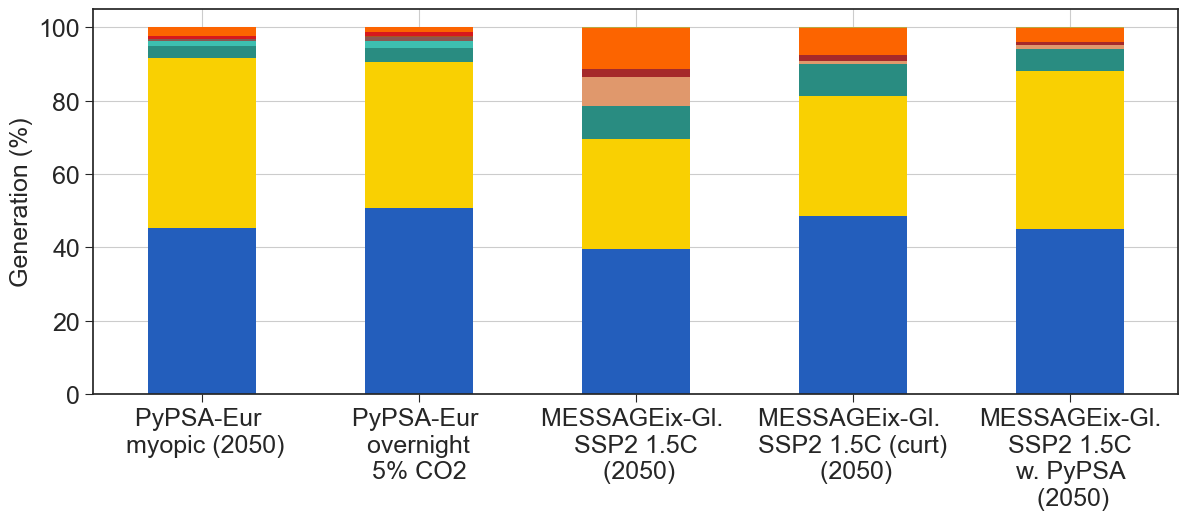

In [152]:
# filter out technologies that have negligible contribution (< 0.01% of total generation)
df_power_generation = df_power_generation.T
# df_power_generation = df_power_generation[df_power_generation > 0.0001*df_power_generation.sum()]
# df_power_generation = df_power_generation.dropna(how='all')

df_power_generation_pctg = df_power_generation.T/df_power_generation.sum(axis=1)*100

df_power_generation_plot = df_power_generation_pctg.T.copy()

preferred_order = pd.Index(["wind","solar","hydro","ror",
                            "biomass CHP","gas CHP",
                            ])

new_columns = preferred_order.intersection(df_power_generation_plot.columns).append(
                                            df_power_generation_plot.columns.difference(preferred_order)
                                            )

fig, ax = plt.subplots(figsize=(14,5))
df_power_generation_plot[new_columns].plot(kind='bar', stacked=True,
                                           ax= ax,
                                            color=[tech_colors[x] for x in new_columns],
                                            legend=False)

# rotate xtick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

ax.set_ylabel("Generation (%)")

ax.grid()

# fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6),
#            ncol=3, fancybox=True, shadow=False, fontsize=fs,
#            frameon=True)

str1 = "_w_pypsa" if add_pypsa_link else ""
fig.savefig("../figures/energy_mix_model_comparison" + str1 + ".png",
            dpi=300,
            bbox_inches='tight')

In [153]:
# add indices to df_power_generation from df_gen_message that are missing
for index in df_cap_message.index:
    if index not in df_power_capacity.index:
        df_power_capacity.loc[index] = 0

# add message generation to df
df_power_capacity["MESSAGEix-Gl. \n SSP2 1.5C \n (2050)"] = df_cap_message
df_power_capacity = df_power_capacity.fillna(0)

# for index in df_cap_message_carbon_price.index:
#     if index not in df_power_capacity.index:
#         df_power_capacity.loc[index] = 0

# # add message generation to df
# df_power_capacity["MESSAGEix-GLOBIOM \n SSP2 1.5C (carbon price)"] = df_cap_message_carbon_price
# df_power_capacity = df_power_capacity.fillna(0)

for index in df_cap_message_only_curt.index:
    if index not in df_power_capacity.index:
        df_power_capacity.loc[index] = 0

# add message generation to df
df_power_capacity["MESSAGEix-Gl. \n SSP2 1.5C (curt) \n (2050)"] = df_cap_message_only_curt
df_power_capacity = df_power_capacity.fillna(0)

if add_pypsa_link:
    for index in df_cap_message_pypsa.index:
        if index not in df_power_capacity.index:
            df_power_capacity.loc[index] = 0

    df_power_capacity["MESSAGEix-Gl. \n SSP2 1.5C \n w. PyPSA (2050)"] = df_cap_message_pypsa
    df_power_capacity = df_power_capacity.fillna(0)

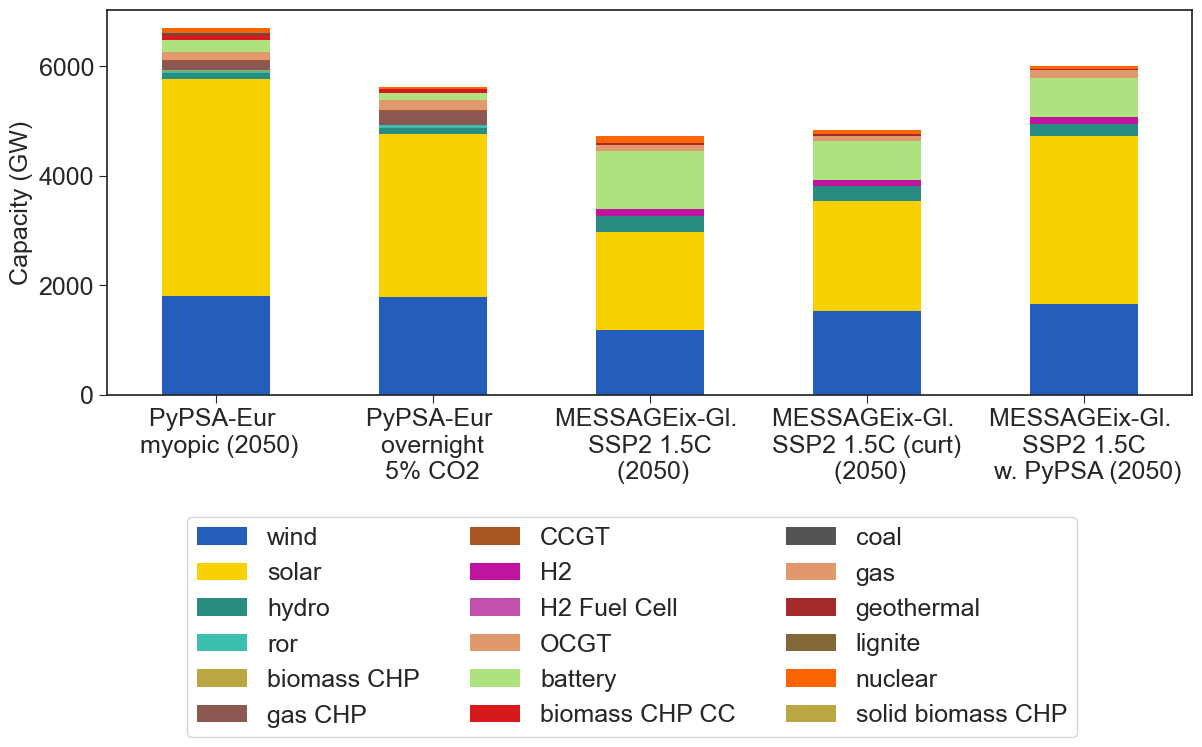

In [163]:
# filter out technologies that have negligible contribution (< 0.01% of total generation)
df_power_capacity_plot = df_power_capacity.copy()
df_power_capacity_plot = df_power_capacity_plot[df_power_capacity_plot > 0.0001*df_power_capacity_plot.sum()]
df_power_capacity_plot = df_power_capacity_plot.dropna(how='all').T

df_power_capacity_plot.drop(columns=["DC"],inplace=True)

preferred_order = pd.Index(["wind","solar","hydro","ror",
                            "biomass CHP","gas CHP",
                            ])

new_columns = preferred_order.intersection(df_power_capacity_plot.columns).append(
                                            df_power_capacity_plot.columns.difference(preferred_order)
                                            )

fig, ax = plt.subplots(figsize=(14,5))
df_power_capacity_plot[new_columns].plot(kind='bar', stacked=True,
                                           ax= ax,
                                            color=[tech_colors[x] for x in new_columns],
                                            legend=False)

# rotate xtick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

ax.set_ylabel("Capacity (GW)")

fig.legend(loc='lower center', 
           bbox_to_anchor=(0.5, -0.6),
           ncol=3, fancybox=True, shadow=False, fontsize=fs,
           frameon=True)

str1 = "_w_pypsa" if add_pypsa_link else ""
fig.savefig("../figures/capacity_mix_model_comparison" + str1 + ".png",
            dpi=300,
            bbox_inches='tight')

In [164]:
table_1 = df_power_capacity_plot["battery"]
table_2 = (df_power_capacity_plot["wind"] + df_power_capacity_plot["solar"])

# merge table_1 and table_2 and make it as Latex table format
table_1 = table_1.rename("Battery (GW)")
table_2 = table_2.rename("VRE (GW)")
table = pd.concat([table_1, table_2], axis=1)
table = table.round(0)
table = table.astype(int)

# add column where VRE is divided by battery
table["VRE/Battery"] = table["VRE (GW)"]/table["Battery (GW)"]
table = table.round(1)

# print the table in latex format in the console such that it can be copied and pasted in the paper
print(table.to_latex())


\begin{tabular}{lrrr}
\toprule
{} &  Battery (GW) &  VRE (GW) &  VRE/Battery \\
\midrule
PyPSA-Eur \textbackslash n myopic (2050)                    &           217 &      5778 &         26.6 \\
PyPSA-Eur \textbackslash n overnight \textbackslash n 5\% CO2              &           120 &      4772 &         39.8 \\
MESSAGEix-Gl. \textbackslash n SSP2 1.5C \textbackslash n (2050)          &          1073 &      2973 &          2.8 \\
MESSAGEix-Gl. \textbackslash n SSP2 1.5C (curt) \textbackslash n (2050)   &           717 &      3531 &          4.9 \\
MESSAGEix-Gl. \textbackslash n SSP2 1.5C \textbackslash n w. PyPSA (2050) &           710 &      4721 &          6.6 \\
\bottomrule
\end{tabular}



C:\Users\au485969\AppData\Local\Temp\ipykernel_19108\3641365122.py:16: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



In [61]:
table

,Battery (GW),VRE (GW),VRE/Battery
PyPSA-Eur \n myopic (2050),217,5778,26.6
PyPSA-Eur \n overnight \n 5% CO2,120,4772,39.8
MESSAGEix-Gl. \n SSP2 1.5C \n (2050),1073,2973,2.8
MESSAGEix-Gl. \n SSP2 1.5C (curt) \n (2050),717,3531,4.9
MESSAGEix-Gl. \n SSP2 1.5C \n w. PyPSA (2050),710,4721,6.6
